In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import random
from pathlib import Path

import torch
import numpy as np

sys.path.append('..')
import zsl

In [4]:
BASE_PATH = Path('../data/birds')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Set random seeds for reproducibility.  

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Getting ready for Zero Shot Learning

1. Split the classes in Zero Shot Classes and non Zero Shot. In other words, decide which classes are going to be available during training, and which not.
2. Declare a function that given the class name, looks for the bird description on wikipedia.

In [6]:
with (BASE_PATH / 'BIRDS-150.txt').open() as f:
    all_classes = [c.split(':')[1] for c in f.read().split(',') if c]

print('Number of classes:', len(all_classes))

Number of classes: 150


### Split the classes

Define a probability $P(C)$ that given a class $C$ it belogs to he Zero Shot Classes. In our case, we set a 20% of the classes.

$ P(C) = 0.2 $

In [7]:
PC = .2
zs_classes = []
classes = []

for c in all_classes:
    if random.random() < PC:
        zs_classes.append(c)
    else: 
        classes.append(c)

print('Number of ZS classes:', len(zs_classes))
print('Number of NON-ZS classes:', len(classes))

Number of ZS classes: 26
Number of NON-ZS classes: 124


### Define a function to describe the labels

The text that describes the labels (birds), will come from wikipedia. To retrieve text from wikipedia corpus, we are going to use a convinient python package called `wikipedia`. With `wikipedia` package, we can retrieve summaries of the birds with a concrete number of sentences.

Later, we are going to encode the birds summaries in order they matches with a pretrined embedding vocabulary, for example GloVE vectors.


In [8]:
import wikipedia
wikipedia.set_lang('en')

`zsl` provides a method to create summaries coming from wikipedia.

In [10]:
zsl.utils.wikipedia_description(classes[3], sentences=2)

'The American bittern (Botaurus lentiginosus) is a species of wading bird in the heron family. It has a Nearctic distribution, breeding in Canada and the northern and central parts of the United States, and wintering in the U.S. Gulf Coast states, all of Florida into the Everglades, the Caribbean islands and parts of Central America.'

We can see that wikipedia text contains a lot of uppercase letters and punctuations that we are not interested in. Thanks to `wikipedia_description` function, we can do some simple text cleaning. 

In [11]:
import functools

summary_fn = functools.partial(zsl.utils.wikipedia_description,
                               remove_punct=True,
                               to_lower=True)

summary_fn(zs_classes[3], sentences=2)

'the crested auklet  aethia cristatella  is a small seabird of the family alcidae  distributed throughout the northern pacific and the bering sea   the species feeds by diving in deep waters  eating krill and a variety of small marine animals '

Get descriptions for all labels, so later we can generate a vocabulary.

In [12]:
# Map some classes that are not directly found in wikipedia
mapping_unknown = {
    'CHARA DE COLLAR': 'Cyanolyca armillata',
    'CURL CRESTED ARACURI': 'Pteroglossus beauharnaisii',
    'MYNA': 'MYNA BIRD',
    'RED WISKERED BULBUL': 'Red-whiskered bulbul',
    'ROBIN': 'Robin BIRD',
    'TEAL DUCK': 'Eurasian teal',
    'WILSONS BIRD OF PARADISE': 'Wilson\'s bird-of-paradise'}

all_texts = [summary_fn(mapping_unknown.get(c, c)) for c in all_classes]

We build a vocabulary using torchtext.

In [16]:
import torchtext

counter = torchtext.vocab.Counter(' '.join(all_texts).split())
vocab = torchtext.vocab.Vocab(counter, vectors=torchtext.vocab.GloVe(name='6B', dim=50))

.vector_cache/glove.6B.zip: 862MB [06:38, 2.16MB/s]                               
 99%|█████████▉| 397902/400000 [00:13<00:00, 29068.27it/s]

Now that we have our vocabulary ready, we can see the semantic representation of any word.

For instance, let's see 'bird' representation

In [17]:
vocab.vectors[vocab.stoi['bird']]

tensor([ 0.7868,  0.0794, -0.7660,  0.1931,  0.5501,  0.2649, -0.7584, -0.8818,
         1.6468, -0.5438,  0.3352,  0.4440,  1.0890,  0.2704,  0.7447,  0.2487,
         0.2491, -0.2897, -1.4556,  0.3561, -1.1725, -0.4986,  0.3535, -0.1418,
         0.7173, -1.1416, -0.0387,  0.2752, -0.0177, -0.4401,  1.9597, -0.0647,
         0.4718, -0.0300, -0.3162,  0.2698,  0.5620, -0.2788, -0.3636, -0.2192,
        -0.7505,  0.3182,  0.2935,  0.2511,  1.6111,  0.7134, -0.1524, -0.2536,
         0.2642,  0.1587])

Finally we can create the function that maps a class to a tokenized description.
Later, we will convert tokens to semantic representation using an `nn.Embedding` containing the semantic representations.

In [20]:
def class_to_semantic(class_name):
    
    # Map the class to known words
    class_name = mapping_unknown.get(class_name, class_name)

    # Look for the description in wikipedia
    desc = summary_fn(class_name, sentences=2)

    # Tokenize and return the description
    return torch.LongTensor([vocab.stoi[w] for w in desc.split()])

print('Description of', zs_classes[0])
class_to_semantic(zs_classes[0])

Description of BLACKBURNIAM WARBLER


tensor([   2, 1328,  173,  587, 1503,  196, 2567, 1503,    6,    7,   41,   58,
          60,  173,   21,  292,    5,   88,   27,   31,   18,   70,  142, 4147,
           8,    2,   70,  966, 3508,    2,  143,  345,  862,    3,   58,  782,
           8,   27,  616])

Now we have already done one of the most complex tasks of Zero Shot Learning: Generating a semantic representation for the labels.

Now it is time to index our data using Pytorch datasets.

In [21]:
train_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'train', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    load_unseen=False) # In training set we don't load zs classes

val_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'valid', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    load_unseen=True)

test_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'valid', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    load_unseen=True)

Label: MYNA
Description: the myna also spelled mynah is a bird of the starling family sturnidae this is a group of passerine birds which are native to southern asia especially india pakistan and bangladesh


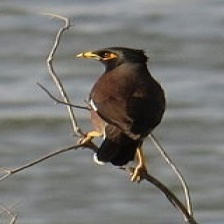

In [22]:
idx = random.randint(0, len(train_ds))
image, label, semantic = train_ds[idx]
print('Label:', train_ds.classes[label])
print('Description:', ' '.join(vocab.itos[i] for i in semantic.tolist()))

image